This Jupyter notebook implements a Support Vector Machine (SVM) model for fake news detection, including data preprocessing, model training with hyperparameter tuning, evaluation using various metrics and visualizations, and a function for making predictions on new text inputs.

In [84]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

This code downloads the Punkt tokenizer models and stopwords list from NLTK, which are essential for text preprocessing tasks such as sentence tokenization and stopword removal in the fake news detection model.

In [63]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\belmo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\belmo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

This code loads a custom dataset named "dataset_train_thesis" from the Hugging Face Datasets library, which is likely a dataset specifically created for training a thesis-related machine learning model.

In [64]:
# Load the dataset
dataset = load_dataset("nixbel/dataset_train_thesis")

This code converts the loaded dataset's 'train' split into a pandas DataFrame, facilitating easier data manipulation and analysis for the subsequent steps in the machine learning pipeline.

In [65]:
# Convert to pandas DataFrame for easier manipulation
data = dataset['train'].to_pandas()



This code converts the 'Label' column to binary values (0 for credible, 1 for suspicious) and displays the first few rows of the resulting DataFrame, allowing for a quick verification of the label encoding and overall data structure.

In [66]:
# Ensure labels are binary (0 for credible, 1 for suspicious)
data['Label'] = data['Label'].map({'Credible': 0, 'Suspicious': 1})
data.head()



,Headline,Authors,Date,Content,Brand,URL,Label
0,Carlo Paalam outclasses Irish foe to zero in o...,delfin.dioquino editor,31/07/2024 22:35,WINNER. Boxer Carlo Paalam of the Philippines ...,Rappler,https://www.rappler.com/sports/boxing/fight-re...,0
1,"Fishing banned in Limay, Bataan due to oil spill",Iya Gozum,30/07/2024 16:02,Members of the Philippine Coast Guard create i...,Rappler,https://www.rappler.com/philippines/luzon/fish...,0
2,"No POGOs inside Cagayan special economic zone,...",Joann Manabat - CMS,31/07/2024 17:40,'NO POGOS IN CEZA.' Cagayan Economic Zone Auth...,Rappler,https://www.rappler.com/philippines/luzon/ceza...,0
3,Pizza for a cause! a mano and Toyo Eatery coll...,Steph Arnaldo,31/07/2024 17:59,"MANILA, Philippines – Ever had tortang talong ...",Rappler,https://www.rappler.com/life-and-style/food-dr...,0
4,Tiramisu inventor Roberto Linguanotto dies at 81,jreyes0314,31/07/2024 18:15,TIramisu inventor Roberto Linguanotto dies at ...,Rappler,https://www.rappler.com/life-and-style/food-dr...,0


This code defines a text preprocessing function that performs several operations on input text: converting to lowercase, removing special characters and numbers, tokenizing, removing stopwords, and rejoining the processed tokens into a single string, which is crucial for preparing the text data for machine learning models.

In [68]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Join tokens back into string
    return ' '.join(tokens)



This code applies the previously defined `preprocess_text` function to the 'Content' column of the DataFrame, creating a new 'Processed_Content' column with the preprocessed text, which prepares the data for feature extraction and subsequent model training.

In [69]:
# Apply preprocessing to the 'text' column
data['Processed_Content'] = data['Content'].apply(preprocess_text)


This code splits the preprocessed content and corresponding labels into training and testing sets, using 80% of the data for training and 20% for testing, with a fixed random state for reproducibility.

In [70]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data['Processed_Content'], data['Label'], test_size=0.2, random_state=42)

This code creates a TF-IDF vectorizer with a maximum of 5000 features and unigrams/bigrams, then applies it to transform the training and testing text data into numerical feature vectors suitable for machine learning models.

In [71]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



This code defines a Support Vector Machine (SVM) model with a radial basis function (RBF) kernel, enabling probability estimates and setting a fixed random state for reproducibility, which will be used for classifying the preprocessed and vectorized text data.

In [72]:
# Define SVM model
svm = SVC(kernel='rbf', probability=True, random_state=42)



This code defines a parameter grid for GridSearchCV, specifying different values for the 'C' and 'gamma' hyperparameters of the SVM model, which will be used to find the optimal combination of these parameters during the model tuning process.

In [73]:
# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
}



This code performs a grid search with cross-validation to find the optimal hyperparameters for the SVM model, trains the model on the entire training set using these parameters, and then assigns the best-performing model to the variable `best_svm` for further use in the fake news detection pipeline.

In [74]:
# Perform GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Get best model
best_svm = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


This code evaluates the best SVM model on the test set, prints accuracy and a detailed classification report, and defines a `predict_fake_news` function for making predictions on new text inputs, which includes text preprocessing, vectorization, and returning both the prediction and probability of being suspicious.

In [75]:
# Evaluate on the test set
y_pred = best_svm.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Accuracy on test set: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Function for inference
def predict_fake_news(text, model, vectorizer):
    processed_text = preprocess_text(text)
    tfidf_vector = vectorizer.transform([processed_text])
    prediction = model.predict(tfidf_vector)[0]
    probability = model.predict_proba(tfidf_vector)[0][1]
    return prediction, probability



Best parameters: {'C': 10, 'gamma': 'scale'}
Accuracy on test set: 0.9731

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1375
           1       0.98      0.97      0.97      1190

    accuracy                           0.97      2565
   macro avg       0.97      0.97      0.97      2565
weighted avg       0.97      0.97      0.97      2565





This code generates and displays a confusion matrix heatmap for the SVM model's predictions on the test set, providing a visual representation of the model's performance in terms of true positives, true negatives, false positives, and false negatives.

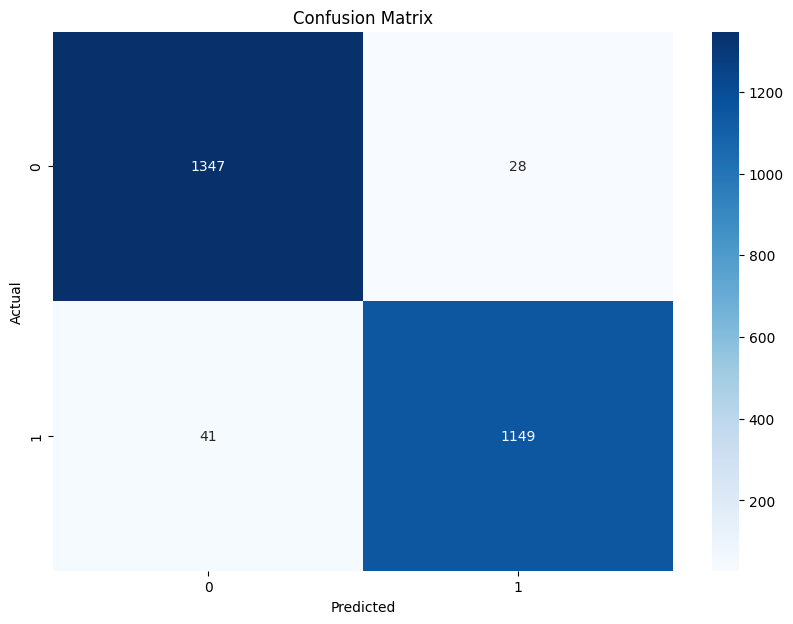

In [78]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



This code calculates and plots the Receiver Operating Characteristic (ROC) curve for the SVM model, including the Area Under the Curve (AUC) score, which provides a visual and quantitative assessment of the model's ability to distinguish between the two classes (credible and suspicious news) across various classification thresholds.

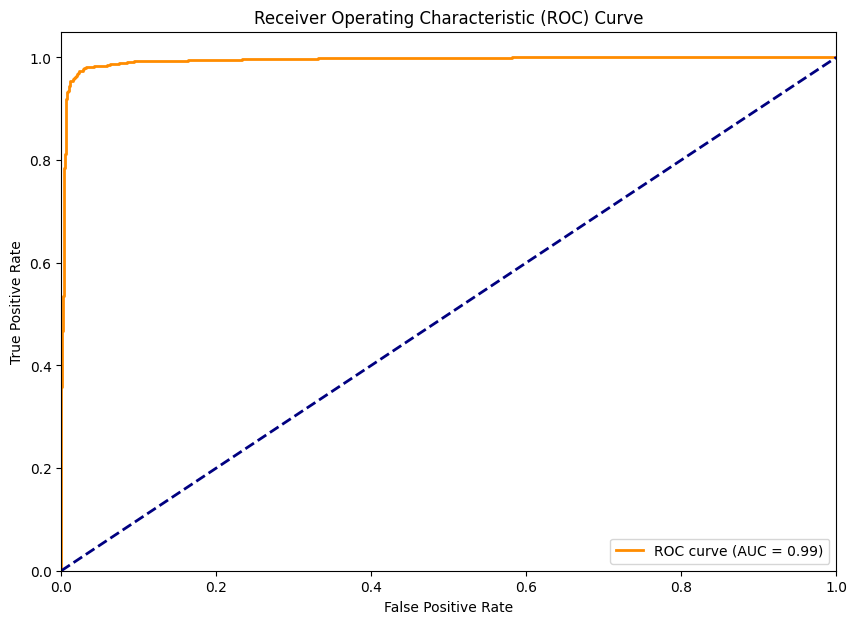

In [80]:
# ROC Curve
y_pred_proba = best_svm.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

This code calculates and plots the Precision-Recall curve for the SVM model, including the Area Under the Curve (AUC) score, which provides a visual and quantitative assessment of the model's performance in terms of precision and recall across different classification thresholds, particularly useful for imbalanced datasets.

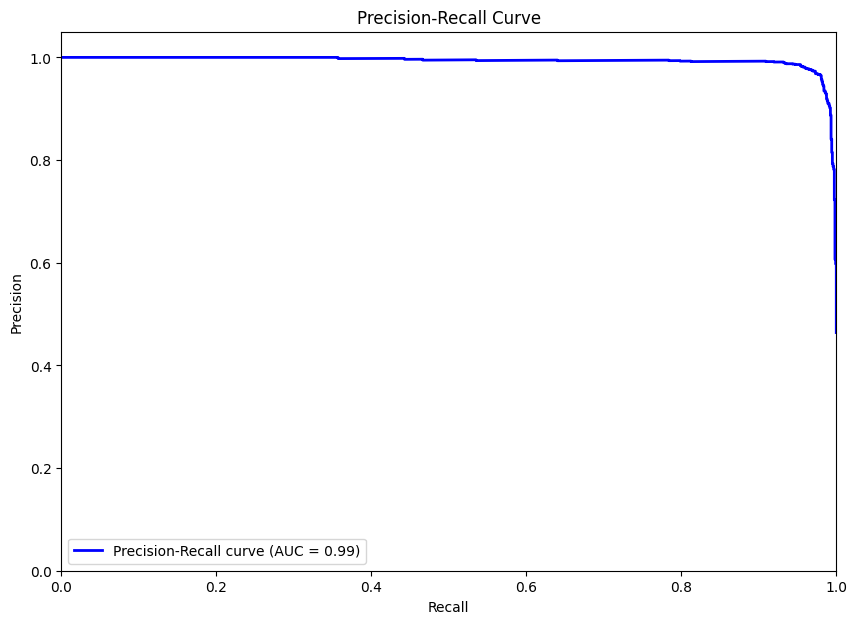

In [81]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(10,7))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


This code defines two functions:

1. `predict_fake_news`: This function takes a text input, preprocesses it, transforms it using the TF-IDF vectorizer, and then uses the trained SVM model to predict whether the text is suspicious or credible, returning both the prediction and the probability of being suspicious.

2. `user_input_inference`: This function creates an interactive loop where users can input news article text. It calls `predict_fake_news` for each input and displays the prediction and probability. The loop continues until the user types 'quit'.

Finally, the code calls `user_input_inference` with the best SVM model and vectorizer, allowing users to test the fake news detection model with their own inputs.

In [ ]:
def predict_fake_news(text, model, vectorizer):
    processed_text = preprocess_text(text)
    tfidf_vector = vectorizer.transform([processed_text])
    prediction = model.predict(tfidf_vector)[0]
    probability = model.predict_proba(tfidf_vector)[0][1]
    return prediction, probability

def user_input_inference(model, vectorizer):
    while True:
        user_text = input("Enter a news article text (or 'quit' to exit): ")
        if user_text.lower() == 'quit':
            break
        
        prediction, probability = predict_fake_news(user_text, model, vectorizer)
        
        print(f"\nPrediction: {'Suspicious' if prediction == 1 else 'Credible'}")
        print(f"Probability of being Suspicious: {probability:.4f}")
        print("\n" + "-"*50 + "\n")

# Call the function for user input and inference
user_input_inference(best_svm, vectorizer)

This code saves the trained SVM model and TF-IDF vectorizer to disk using pickle, allowing them to be easily loaded and reused in future sessions or applications without the need to retrain the model or recreate the vectorizer.

Specifically:
1. The best SVM model is saved as 'svm_model.pkl'
2. The TF-IDF vectorizer is saved as 'tfidf_vectorizer.pkl'
3. A success message is printed to confirm the saving process

These saved files can be later loaded to make predictions on new data without having to retrain the entire model.

In [86]:
# Save the SVM model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(best_svm, f)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.
